# Advanced Lane Finding

## Extracting images for camera calibration

In [90]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

images_list=glob.glob('./camera_cal/calibration*.jpg')

obj_pts = [] #3-D points in the real world space
img_pts = [] #2-D points on the image plane

objp = np.zeros((9*6,3),np.float32)
objp[:,:2] =np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images_list:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    if ret==True:
        img_pts.append(corners)
        obj_pts.append(objp)
        
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)

### Undistort images

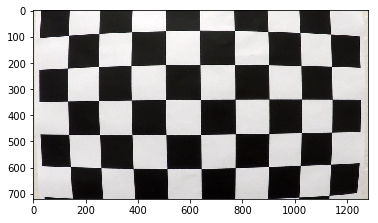

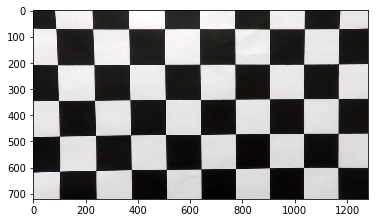

In [91]:
test_img = mpimg.imread('./camera_cal/calibration1.jpg')
gray = cv2.cvtColor(test_img,cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(test_img)
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(obj_pts,img_pts,gray.shape[::-1],None,None)
undistort = cv2.undistort(test_img,mtx,dist,None,mtx)
plt.figure()
plt.imshow(undistort)

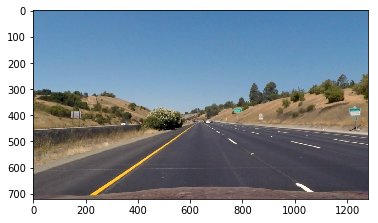

In [145]:
image = mpimg.imread('./test_images/straight_lines1.jpg')
undistort = cv2.undistort(image,mtx,dist,None,mtx)
cv2.imwrite('./output_images/Test_img_undistorted.png',undistort)
plt.figure()
plt.imshow(undistort)

## Color and Gradient Thrsholding

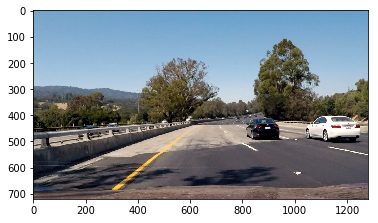

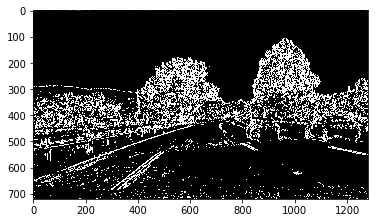

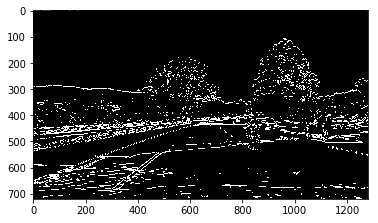

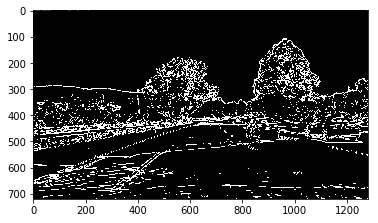

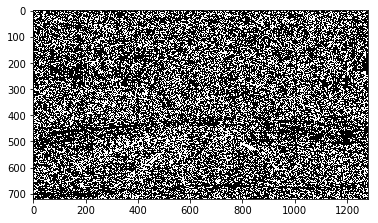

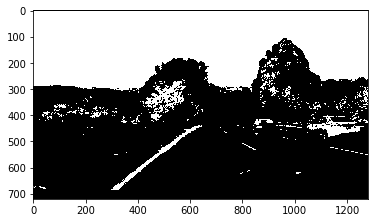

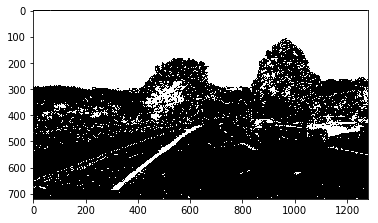

In [92]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_out = np.zeros_like(scaled_sobel)
    binary_out[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_out

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    grad_mag = np.sqrt((sobelx**2) + (sobely**2))
    scaled_gradmag = np.uint8(255*grad_mag/np.max(grad_mag))
    binary_out = np.zeros_like(scaled_gradmag)
    binary_out[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return binary_out

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    dir_grad=np.arctan2(abs_sobely,abs_sobelx)
    binary_out=np.zeros_like(dir_grad)
    binary_out[(dir_grad>=thresh[0]) & (dir_grad<=thresh[1])]=1
    return binary_out

def color_threshold(img,thresh1=(0,255),thresh2=(0,255)):
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh1[0]) & (s_channel <= thresh1[1])] = 1
    
    hsv_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v_channel = hsv_img[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= thresh2[0]) & (v_channel <= thresh2[1])] = 1
    
    binary_out = np.zeros_like(v_channel)
    binary_out[(s_binary == 1) & (v_binary == 1)] = 1
#     binary_out = s_binary
    
    return binary_out

# def preprocess(image):
#     hsv_img = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
#     hsv_img[:,:,2] = cv2.equalizeHist(image[:,:,2])
#     rgb_img = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
#     return rgb_img

image = mpimg.imread('./test_images/test4.jpg')
plt.figure()
plt.imshow(image)
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10,100))
plt.figure()
plt.imshow(gradx,cmap='gray')
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30,100))
plt.figure()
plt.imshow(grady,cmap='gray')
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30,100))
plt.figure()
plt.imshow(mag_binary,cmap='gray')
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.3))
plt.figure()
plt.imshow(dir_binary,cmap='gray')
color_binary = color_threshold(image,thresh1=(90,255), thresh2=(50,255))
plt.figure()
plt.imshow(color_binary,cmap='gray')

combined = np.zeros_like(color_binary)
combined[((gradx == 1) & (grady == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1
plt.figure()
plt.imshow(combined,cmap='gray')

True

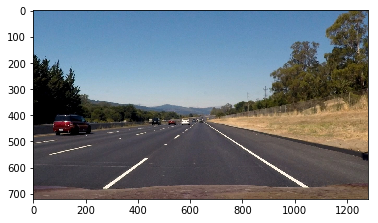

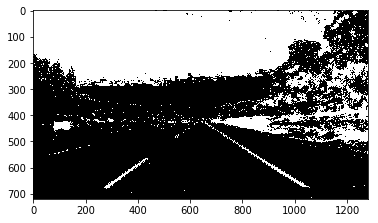

In [154]:
def preprocess(image):
#     plt.figure()
#     plt.imshow(image)

    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20,100))
#     plt.figure()
#     plt.imshow(gradx,cmap='gray')
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20,100))
#     plt.figure()
#     plt.imshow(grady,cmap='gray')
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30,100))
#     plt.figure()
#     plt.imshow(mag_binary,cmap='gray')
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.3))
#     plt.figure()
#     plt.imshow(dir_binary,cmap='gray')
    color_binary = color_threshold(image,thresh1=(90,255), thresh2=(50,255))
#     plt.figure()
#     plt.imshow(color_binary,cmap='gray')

    # shadow_corrected_binary = shadow_corr(image,thresh=(20,90))
    # plt.figure()
    # plt.imshow(shadow_corrected_binary,cmap='gray')

    combined = np.zeros_like(color_binary)
    combined[((gradx == 1) & (grady == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1
#     plt.figure()
#     plt.imshow(combined,cmap='gray')

#     cv2.imwrite("processed_image.jpg",image)
    
    return combined

image = mpimg.imread('./test_images/straight_lines2.jpg')
# from moviepy.editor import VideoFileClip
# video = VideoFileClip('challenge_video.mp4')
# image = video.get_frame((0,1))

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(preprocess(image),cmap="gray")
tmp_img = preprocess(image)
out_img = np.dstack((tmp_img,tmp_img,tmp_img))*255
cv2.imwrite('./output_images/thresholded_img.png',out_img)

## Perspective Transform of the images

True

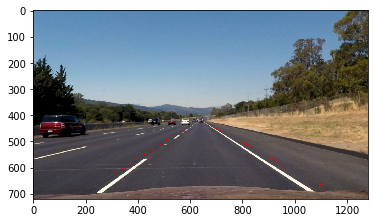

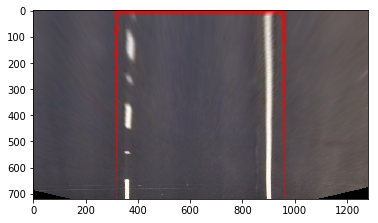

In [153]:
src = np.float32([((image.shape[1]/2)-405,image.shape[0]-50),((image.shape[1]/2)-55,(image.shape[0]/2)+90),((image.shape[1]/2)+60,(image.shape[0]/2)+90),((image.shape[1]/2)+470,image.shape[0]-50)])
offset = image.shape[1]*0.25

dst = np.float32([(offset,image.shape[0]),(offset,0),(image.shape[1]-offset,0),(image.shape[1]-offset,image.shape[0])])
undistort = cv2.undistort(image,mtx,dist,None,mtx)
# binary_out_img = preprocess(undistort)

pts = np.array(src, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(undistort,[pts],True,(255,0,0))
cv2.imwrite('processed_image.jpg',undistort)
plt.figure()
plt.imshow(undistort)

def perspective_transform(combined):
    imgsize = (combined.shape[1],combined.shape[0])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(combined,M,imgsize)
#     plt.imshow(warped,cmap='gray')
    return warped
plt.figure()
plt.imshow(perspective_transform(undistort),cmap='gray')
out_img =perspective_transform(undistort)
# out_img = np.dstack((tmp_img,tmp_img,tmp_img))*255
cv2.imwrite('processed_image2.jpg',out_img)

In [155]:
class lane_tracker():
    
    def __init__(self, n_windows=9, margin=100,min_pix=50, ypixel_conv=1, xpixel_conv=1, smoothing_samples=12):
        #was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients of the last n fits
        self.recent_left_fitx = [] 
        self.recent_right_fitx = []
        # x values of the last n fits of the line
        self.recent_left_x = [] 
        self.recent_right_x = []
        #average x values of the fitted line over the last n iterations
        self.best_leftx = None  
        self.best_rightx = None
        
        self.num_of_windows = n_windows
        self.window_margin = margin
        self.min_pixels = min_pix
        self.ym_per_pixel = ypixel_conv
        self.xm_per_pixel = xpixel_conv
        self.num_smoothing_samples = smoothing_samples
    def sliding_window_tracker(self, warped):
        histogram = np.sum(warped[warped.shape[0]//2:,:],axis=0)
        # plt.figure()
        # plt.plot(histogram)
        midpoint = histogram.shape[0]//2
        leftx = np.argmax(histogram[:midpoint])
        rightx = np.argmax(histogram[midpoint:])+midpoint
        
        leftx_list = []
        rightx_list = []
        # print(leftx)
        # print(rightx)
        num_windows = self.num_of_windows
        window_height = warped.shape[0]//num_windows
        #width of the window from the center
        margin = self.window_margin
        #minimum number of pixels for recentering the window
        minpix = self.min_pixels
        #non-zero pixels in the binary warped image
        nonzero_pix = warped.nonzero()
        # print(nonzero_pix)
        nonzeroy = np.array(nonzero_pix[0])
        # print(nonzeroy)
        nonzerox = np.array(nonzero_pix[1])
        # print(nonzerox)
        #Convert into color image for visualization
        warped_rgb = np.dstack((warped,warped,warped))*255

        leftx_list.append(leftx)
        rightx_list.append(rightx)

        left_lane_inds = []
        right_lane_inds = []
        for n in range(1,num_windows):
            window_upper = warped.shape[0]-window_height*(n+1)
            window_lower = window_upper + window_height
            left_lane_leftx = leftx-margin
            left_lane_rightx = leftx+margin
            right_lane_leftx = rightx-margin
            right_lane_rightx = rightx+margin
            cv2.rectangle(warped_rgb,(left_lane_leftx, window_upper),(left_lane_rightx,window_lower),(0,255,0),3)
            cv2.rectangle(warped_rgb,(right_lane_leftx,window_upper),(right_lane_rightx,window_lower),(0,255,0),3)
            good_left_lane_pix = ((nonzeroy>window_upper) & (nonzeroy<=window_lower) & (nonzerox>left_lane_leftx) & (nonzerox<=left_lane_rightx)).nonzero()[0]
        #     print(((nonzeroy>window_upper) & (nonzeroy<=window_lower) & (nonzerox>left_lane_leftx) & (nonzerox<=left_lane_rightx)).nonzero())
        #     print(((nonzeroy>window_upper) & (nonzeroy<=window_lower) & (nonzerox>left_lane_leftx) & (nonzerox<=left_lane_rightx)))
            good_right_lane_pix = ((nonzeroy>window_upper) & (nonzeroy<=window_lower) & (nonzerox>right_lane_leftx) & (nonzerox<=right_lane_rightx)).nonzero()[0]
        #     print(good_right_lane_pix)
#             left_lane_inds.append(good_left_lane_pix)
#             right_lane_inds.append(good_right_lane_pix)

            if len(good_left_lane_pix)>minpix:
                leftx = np.int(np.mean(nonzerox[good_left_lane_pix]))
            if len(good_right_lane_pix)>minpix:
                rightx = np.int(np.mean(nonzerox[good_right_lane_pix]))
            leftx_list.append(leftx)
            rightx_list.append(rightx)
            
        self.recent_left_x.append(leftx_list)
        self.recent_right_x.append(rightx_list)
        self.best_leftx = np.average(self.recent_left_x[-self.num_smoothing_samples:],axis=0)
        self.best_rightx = np.average(self.recent_right_x[-self.num_smoothing_samples:],axis=0)
        return (self.best_leftx,self.best_rightx)

In [156]:
num_windows = 9
ym_per_pixel = 3/110
xm_per_pixel = 3.7/554
tracker = lane_tracker(n_windows = num_windows)
def process_image(image):
    undistort = cv2.undistort(image,mtx,dist,None,mtx)
    binary_out_img = preprocess(undistort)
    warped_img = perspective_transform(binary_out_img)
    
    best_leftx, best_rightx = tracker.sliding_window_tracker(warped_img)
    window_height = warped_img.shape[0]//num_windows
    yvals = np.linspace(0,warped_img.shape[0]-1,warped_img.shape[0])
    win_yvals = np.arange(warped_img.shape[0]-(window_height/2),0,-window_height)
    
#     from IPython.core.debugger import Tracer; Tracer()()
    
    left_fit = np.polyfit(win_yvals,best_leftx,2)
    right_fit = np.polyfit(win_yvals,best_rightx,2)
    
    left_fitx = left_fit[0]*(yvals*yvals) + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*(yvals*yvals) + right_fit[1]*yvals + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
#     plt.imshow(result)

    curve_fit = np.polyfit(np.array(win_yvals,np.float32)*ym_per_pixel, np.array(best_leftx,np.float32)*xm_per_pixel,2)
    curverad = ((1+ (2*curve_fit[0]*yvals[-1]*ym_per_pixel + curve_fit[1])**2)**1.5)/np.absolute(2*curve_fit[0])
    
    #The offset of the car on the road
    camera_center = (left_fitx[-1]+right_fitx[-1])/2
    center_diff = (camera_center - (warped_img.shape[1]/2))*xm_per_pixel
    side = 'left'
    if center_diff<=0:
        side = 'right'
    cv2.putText(result, 'Radius of curvature = '+str(round(curverad,3))+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side+' of the center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    return result

In [157]:
from moviepy.editor import VideoFileClip
white_output = 'test_videos_output/output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/output_video.mp4
[MoviePy] Writing video test_videos_output/output_video.mp4


100%|█████████▉| 1260/1261 [05:21<00:00,  3.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_video.mp4 

CPU times: user 12min 36s, sys: 1.88 s, total: 12min 37s
Wall time: 5min 22s


In [9]:
# def search_lines(binary_warped,left_fit,right_fit):
#     nonzero = binary_warped.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
#     margin = 100
#     left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
#     left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
#     left_fit[1]*nonzeroy + left_fit[2] + margin))) 

#     right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
#     right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
#     right_fit[1]*nonzeroy + right_fit[2] + margin)))  

#     # Again, extract left and right line pixel positions
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]
#     # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     return ploty,left_fitx,right_fitx



